In [1]:
from  sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch import nn
from torch.utils import tensorboard
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor,Lambda, transforms
from torch.utils.tensorboard import SummaryWriter
import torchvision
from IPython.display import display_html
# %reload_ext tensorboard
from tensorboard import notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
SEED=0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# T1
## 定义数据集并设置dataloader

In [2]:
class Iris(Dataset):
    def __init__(self,train:bool,transform=None,target_transform=None) -> None:
        super().__init__()

        iris=datasets.load_iris()
        X=iris['data']
        y=iris['target']
        class_idx =[np.where(y==i)[0] for i in range(3)]
        tmp=[train_test_split(X[class_idx[i]],y[class_idx[i]],train_size=0.6,test_size=0.4,random_state=SEED) for i in range(3)]
        X_train,X_test,y_train,y_test=tmp[0]
        for i in range(1,3):
            X_train=np.vstack((X_train,tmp[i][0]))
            X_test=np.vstack((X_test,tmp[i][1]))
            y_train=np.vstack((y_train,tmp[i][2]))
            y_test=np.vstack((y_test,tmp[i][3]))
        y_train=y_train.flatten()
        y_test=y_test.flatten()

        if train:
            self.X=X_train
            self.labels=y_train
        else:
            self.X=X_test
            self.labels=y_test

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        x = self.X[idx,:]
        label = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            label = self.target_transform(label)
        return x,label
# target_transform=Lambda(lambda y:torch.zeros(3).scatter_(dim=0,index=torch.tensor(y,dtype=torch.int64),value=1))#3是数据集中label的种类数,`scatter_`赋值(value=1)在给定的index处 #也就是把它转变成One-hot形式 #这里不用做, pytorch里的交叉熵函数要求输进去的是labels的格式
transform=Lambda(lambda x:torch.tensor(x,dtype=torch.float32,device=device))
target_transform=Lambda(lambda y:torch.tensor(y,dtype=torch.long,device=device))
train_data=Iris(train=True,transform=transform,target_transform=target_transform)
test_data=Iris(train=False,transform=transform,target_transform=target_transform)
train_dataloader = DataLoader(train_data,shuffle=True,batch_size=20)
test_dataloader = DataLoader(test_data,shuffle=True,batch_size=20)

## 定义模型

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self,lr=0.1):
        super(NeuralNetwork, self).__init__()
        self.fc_layer=nn.Sequential(
            nn.Linear(4,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU()
        )# fully connected layer
        self.out_fn=nn.Sequential(
            nn.Linear(20,3),
            nn.Softmax(dim=1)
            )
        self.loss_fn=nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(),lr=lr)

    def forward(self,x):
        x=self.fc_layer(x)
        pred = self.out_fn(x)
        return pred

    def print_model(self):
        #模型结构与参数量
        print("Model structure: ", self, "\n\n")

        for name, param in self.named_parameters():
            print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

    def train_loop(self,dataloader):
        size = len(dataloader.dataset)
        loss_history={}
        for batch,(X,y) in enumerate(dataloader):
            self.optimizer.zero_grad()
            pred = self.__call__(X)
            loss = self.loss_fn(pred,y)
            loss.backward()
            self.optimizer.step()

            loss_history[batch]=loss.item()
        return loss_history

    def test_loop(self,dataloader):
        size = len(dataloader.dataset)
        test_loss,correct = 0,0
        with torch.no_grad():
            for X,y in dataloader:
                pred = self.__call__(X)
                test_loss +=self.loss_fn(pred,y).item()
                correct += (pred.argmax(1)==y).type(torch.float).sum().item()
        test_loss /=size
        correct /=size
        print(f'Test error:\n Accuracy:{correct:>0.1f},avg loss:{test_loss:>8f}')

    def fit(self,dataloader,epoch,writer=None):
        for e in range(epoch):
            loss_history=self.train_loop(dataloader)
            if writer:
                for k,v in loss_history.items():
                    writer.add_scalar('train_loss',v,k*dataloader.batch_size+e*len(dataloader)*dataloader.batch_size)
                    
        print('Done!')

    def eval(self,dataloader):
        self.test_loop(dataloader)
        
writer = SummaryWriter('log_dir/Iris/three layers 4-20-20-3 lr=0.01 relu')
model = NeuralNetwork(lr=0.01).to(device)
model.fit(train_dataloader,10,writer)
model.eval(test_dataloader)

Done!
Test error:
 Accuracy:0.9,avg loss:0.033315


In [4]:
#画网络结构
dataiter = iter(train_dataloader)
x,labels = dataiter.next()
writer.add_graph(model,x)

#画数据分布
def select_n_random(data,labels,n=100):
    '''select n random datapoints and their corresponding labels from a dataset'''
    assert len(data) == len(labels)
    
    perm= torch.randperm(len(data))
    return data[perm][:n],labels[perm][:n]
x,labels = select_n_random(train_data[:][0],train_data[:][1])
features = x.view(-1,4)
writer.add_embedding(features,metadata=labels)

notebook.start('--logdir log_dir')
writer.close()

Reusing TensorBoard on port 6006 (pid 5792), started 21:38:41 ago. (Use '!kill 5792' to kill it.)

 ![结果](tensorboard_res.jpg)
 从结果可以看出, 此处sigmoid作为激活函数可以使结果更快的收敛, 同时, 加深网络层数也会加快收敛, 增多神经元数量会使得收敛变快, 而减小初始学习率则会使得最终结果更好, 但是在训练初期也会收敛的相对更慢一点
# T2
## 数据集操作

In [5]:
transform=transforms.Compose([transforms.ToTensor(),Lambda(lambda x:x.to(device))])#,transforms.Normalize((0.1037,), (0.3081,))
target_transform=Lambda(lambda y:torch.tensor(y,device=device))
train_data=torchvision.datasets.MNIST('data\mnist', train=True, download=True,transform=transform,target_transform=target_transform)
test_data=torchvision.datasets.MNIST('data\mnist', train=False, download=True,transform=transform,target_transform=target_transform)

train_dataloader = DataLoader(train_data,shuffle=True,batch_size=256)
test_dataloader = DataLoader(test_data,shuffle=False,batch_size=256)
def plot_digit(data):
    '''画一个数字'''
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    '''画很多个数字'''
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.avepool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.avepool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

        self.act_fn = nn.Sigmoid()

        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm1d(120)
        self.bn4 = nn.BatchNorm1d(84)

        self.optimizer = torch.optim.SGD(self.parameters(),lr=0.1,momentum=0.9)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x, batch_norm=False):
        x = self.act_fn(self.conv1(x))
        if batch_norm:
            x = self.bn1(x)
        x = self.avepool1(x)

        x = self.act_fn(self.conv2(x))
        if batch_norm:
            x = self.bn2(x)
        x = self.avepool2(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.act_fn(self.fc1(x))
        if batch_norm:
            x = self.bn3(x)
        x = self.act_fn(self.fc2(x))
        if batch_norm:
            x = self.bn4(x)

        x = nn.Softmax( dim=-1)(self.fc3(x))

        return x

    def init_weight(self):
        for layer in self.modules():
            if type(layer) in [nn.Linear, nn.Conv2d]:
                nn.init.xavier_normal_(layer.weight)

    def train_loop(self,dataloader):
        size = len(dataloader.dataset)
        loss_history={}
        correct=0
        for batch,(X,y) in enumerate(dataloader):

            self.optimizer.zero_grad()
            pred = self.__call__(X,batch_norm=True)
            loss = self.loss_fn(pred,y)
            loss.backward()
            self.optimizer.step()

            loss_history[batch]=loss.item()
            correct +=(pred.argmax(1)==y).type(torch.float).sum().item()
        correct /=size
        return loss_history,correct

    def test_loop(self,dataloader):
        size = len(dataloader.dataset)
        test_loss,correct = 0,0
        with torch.no_grad():
            for X,y in dataloader:
                pred = self.__call__(X,batch_norm=True)
                test_loss +=self.loss_fn(pred,y).item()
                correct += (pred.argmax(1)==y).type(torch.float).sum().item()
        test_loss /=size
        correct /=size
        return correct,test_loss

    def predict(self,X):
        with torch.no_grad():
            pred = self.__call__(X,batch_norm=True)
        return pred.argmax(1)
    def fit(self,dataloader,epoch,writer=None,test_while_training=False,test_dataloader=None):
        self.init_weight()
        train_accuracy={}
        test_accuracy={}
        for e in tqdm(range(epoch)):
            loss_history,train_acc=self.train_loop(dataloader)
            if test_while_training:
                test_acc,_=self.test_loop(test_dataloader)
            if writer:
                for k,v in loss_history.items():
                    writer.add_scalar('train_loss',v,k*dataloader.batch_size+e*len(dataloader)*dataloader.batch_size)
                writer.add_scalar('train_accuracy:',train_acc,e)
                writer.add_scalar('test_accuracy:',test_acc,e)
                train_accuracy[e]=train_acc
                test_accuracy[e]=test_acc
        print('Done!')
        return train_accuracy,test_accuracy

    def eval(self,dataloader):
        correct,test_loss= self.test_loop(dataloader)
        print(f'Test error:\n Accuracy:{correct:>0.1f},avg loss:{test_loss:>8f}')

E:\coding\Python\anaconda\anaconda\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
writer = SummaryWriter('log_dir/Mnist')
model = LeNet().to(device)
train_accuray,test_accuray=model.fit(train_dataloader,10,writer,True,test_dataloader)
model.eval(test_dataloader)

100%|██████████| 10/10 [02:39<00:00, 15.91s/it]


Done!
Test error:
 Accuracy:1.0,avg loss:0.005906


actual label: tensor([6, 4, 2, 5, 0, 3, 8, 6, 5, 0])
predict label: tensor([6, 4, 2, 5, 0, 3, 8, 6, 5, 0], device='cuda:0')


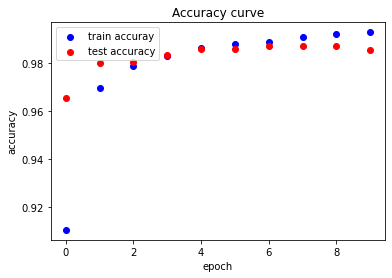

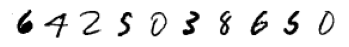

In [7]:
plt.scatter(x=train_accuray.keys(),y=train_accuray.values(),color='blue')
plt.scatter(x=test_accuray.keys(),y=test_accuray.values(),color='red')
plt.legend(['train accuray','test accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy curve')

dataloader = DataLoader(test_data,shuffle=True,batch_size=10)
correct=0
with torch.no_grad():
    # for X,y in dataloader:
    X,y=next(iter(dataloader))
    pred = model(X,batch_norm=True)
    correct += (pred.argmax(1)==y).type(torch.float).sum().item()
h=model.predict(X)
X=X.to('cpu')
y=y.to('cpu')
plt.subplots()
plot_digits(X)
print('actual label:',y)
print('predict label:',h)

 可见分类全部正确, 模型效果不错 \^o^/